# Notebook for the King County housing price prediction 
Author: Johannes Pastorek, johannes.pastorek@gmail.com

In [679]:
reset -fs

In [680]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import geopy.distance

from sklearn.model_selection import cross_validate, train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [681]:
df = pd.read_csv('King_County_House_prices_dataset.csv')

In [682]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Missing Values

- NaNs in 'waterfront' and 'view' are replaced with zero assuming they were left out when not relevant
- some values for 'sqft_basement' had question marks as entry, simply replace 'sqft_basement' by 'sqft_living - 'sqft_above
- features 'yr_built' and 'yr_renovated' are specified in years; better use time since built (age) and time since renovation
- properties that were not renovated were indicated with a zero; replace zeros with the year built

In [683]:
df['waterfront'].fillna(0, inplace=True)
df['waterfront'] = df.waterfront.astype(int)
df['view'].fillna(0, inplace=True)
df['view'] = df.view.astype(int)
df['condition'] = df.condition.astype(int)
df['grade'] = df.grade.astype(int)
df['sqft_basement'] = df.sqft_living - df.sqft_above
df['yr_sold'] = df.date.apply(lambda x: pd.to_datetime(x).year)
df['age'] = df.yr_sold - df.yr_built
df['yr_renovated'].fillna(df.yr_built, inplace=True)
df['yr_renovated'] = df.yr_renovated.replace(0, df.yr_built)
df['time_since_ren'] = df.yr_sold - df.yr_renovated
df['price_per_sqft'] = df.price / df.sqft_living

In [684]:
df.drop(['yr_sold', 'yr_built', 'yr_renovated'], axis=1, inplace=True)

In [685]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id                21597 non-null int64
date              21597 non-null object
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
sqft_lot          21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null int64
view              21597 non-null int64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null int64
zipcode           21597 non-null int64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
age               21597 non-null int64
time_since_ren    21597 non-null float64
price_per_sqft    21597 non-null float64
dtypes: float64(7)

current status:
- no missing values left
- no objects except date left
- zipcode, longitude and latitude are yet to be transformed to something more meaningful
- categorical features view, condition and grade are yet to be transformed

todo:
- leave id, date, zipcode, longitude and latitude out (for now)
- tranform categorical features

## Categorical Features

In [686]:
grade_df = df.groupby('zipcode').mean()[['grade']]
grade_df.rename(columns={"grade": "zip_grade"}, inplace=True)
condition_df = df.groupby('zipcode').mean()[['condition']]
condition_df.rename(columns={"condition": "zip_condition"}, inplace=True)

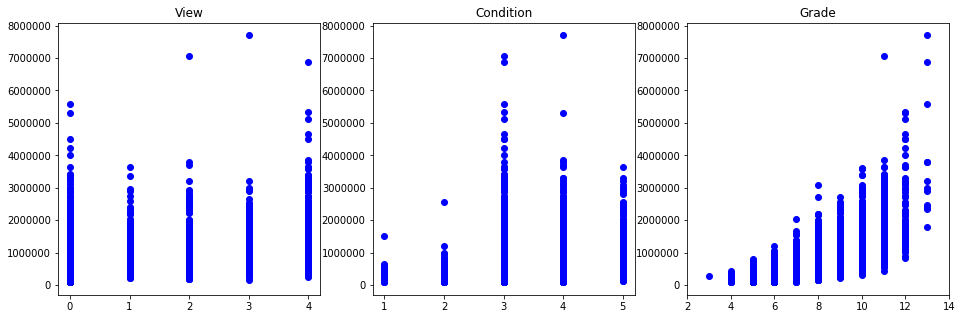

In [687]:
plt.figure(figsize=(9,5)) 

plt.subplot(131)
plt.plot(df.view, df.price, 'bo')
plt.title('View')

plt.subplot(132)
plt.plot(df.condition, df.price, 'bo')
plt.title('Condition')

plt.subplot(133)
plt.plot(df.grade, df.price, 'bo')
plt.title('Grade')
plt.xlim([2,14])

plt.subplots_adjust(right=1.5)

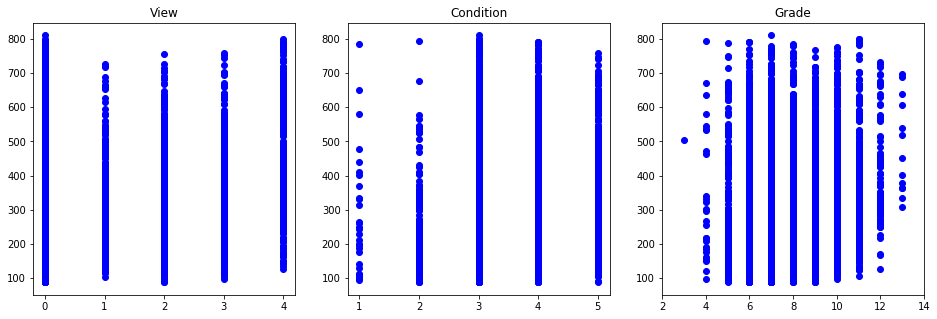

In [688]:
plt.figure(figsize=(9,5)) 

plt.subplot(131)
plt.plot(df.view, df.price_per_sqft, 'bo')
plt.title('View')

plt.subplot(132)
plt.plot(df.condition, df.price_per_sqft, 'bo')
plt.title('Condition')

plt.subplot(133)
plt.plot(df.grade, df.price_per_sqft, 'bo')
plt.title('Grade')
plt.xlim([2,14])

plt.subplots_adjust(right=1.5)

how to handle view, condition and grade:
1. include dummy for each possible state of each feature (drop first)
2. create bigger dummy subsets:
    - view: viewed zero times yes/no
    - condition: bad condition (<= 2) and good condition (> 2)
    - very bad grade (3, 4), mediocre grade (5, 6, 7, 8), good grade (9, 10, 11), very good grade (12, 13)
3. keep them as is
4. drop view, condition and grade altogether   

### Include dummies for each possible state

In [689]:
df1 = df.copy()

In [690]:
view_dummies = pd.get_dummies(df1.view, prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(df1.condition, prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(df1.grade, prefix='grade', drop_first=True)

df1 = df1.join(view_dummies)
df1 = df1.join(condition_dummies)
df1 = df1.join(grade_dummies)

In [691]:
df1.drop(['view', 'condition', 'grade'], axis=1, inplace=True)

In [692]:
X1 = df1.drop(['price', 'price_per_sqft', 'date', 'id', 'zipcode', 'lat', 'long'], axis=1)
X1 = sm.add_constant(X1)
y1 = df1.price

sm.OLS(y1, X1).fit().summary()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1608.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:41   Log-Likelihood:            -2.9496e+05
No. Observations:               21597   AIC:                         5.900e+05
Df Residuals:                   21567   BIC:                         5.902e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.03e+05   2.11e+05     -1.439      0.150   -7.16e+05     1.1e+05
bedrooms         -2.5e+04   1989.792    -12.564      0.000   -2.89e+04   -2.11e+04
bathrooms        4.77e+04   3377.977     14.122      0.000    4.11e+04    5.43e+04
sqft_living       87.7502      2.389     36.739      0.000      83.069      92.432
sqft_lot           0.0084      0.049      0.171      0.864      -0.088       0.105
floors          4.501e+04   3694.192     12.185      0.000    3.78e+04    5.23e+04
waterfront      5.344e+05    2.1e+04     25.493      0.000    4.93e+05    5.75e+05
sqft_above        27.8875      2.347     11.884      0.000      23.288      32.487
sqft_basement     59.8627      2.675     22.380      0.000      54.620      65.106
sqft_living15     32.0653      3.489      9.190      0.000      25.226      38.904
sqft_lot15        -0.5428      0.075     -7.233      0.000      -0.690      -0.396
age             3795.3631    129.442     29.321      0.000    3541.647    4049.079
time_since_ren  -615.6927    134.953     -4.562      0.000    -880.211    -351.175
view_1          1.126e+05   1.16e+04      9.690      0.000    8.98e+04    1.35e+05
view_2          4.865e+04   7052.054      6.899      0.000    3.48e+04    6.25e+04
view_3          1.012e+05   9650.733     10.481      0.000    8.22e+04     1.2e+05
view_4          2.411e+05   1.46e+04     16.500      0.000    2.12e+05     2.7e+05
condition_2     2.498e+04   4.17e+04      0.599      0.549   -5.67e+04    1.07e+05
condition_3     5.184e+04   3.88e+04      1.337      0.181   -2.42e+04    1.28e+05
condition_4     7.003e+04   3.88e+04      1.806      0.071   -5977.047    1.46e+05
condition_5     1.105e+05    3.9e+04      2.834      0.005    3.41e+04    1.87e+05
grade_4          3.26e+04   2.11e+05      0.155      0.877    -3.8e+05    4.45e+05
grade_5         2.877e+04   2.07e+05      0.139      0.890   -3.77e+05    4.35e+05
grade_6         8.208e+04   2.07e+05      0.397      0.691   -3.23e+05    4.87e+05
grade_7         1.584e+05   2.07e+05      0.766      0.444   -2.47e+05    5.64e+05
grade_8         2.411e+05   2.07e+05      1.166      0.244   -1.64e+05    6.47e+05
grade_9         3.806e+05   2.07e+05      1.839      0.066    -2.5e+04    7.86e+05
grade_10        5.599e+05   2.07e+05      2.705      0.007    1.54e+05    9.66e+05
grade_11        8.285e+05   2.07e+05      3.996      0.000    4.22e+05    1.23e+06
grade_12        1.301e+06   2.08e+05      6.246      0.000    8.93e+05    1.71e+06
grade_13        2.514e+06   2.15e+05     11.674      0.000    2.09e+06    2.94e+06
==============================================================================
Omnibus:                    12709.007   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           498350.459
Skew:                   

### Create own dummy segmentation

In [693]:
df2 = df.copy()

2. create bigger dummy subsets:
    - view: viewed zero times yes/no
    - condition: bad condition (<= 2) and good condition (> 2)
    - very bad grade (3, 4), mediocre grade (5, 6, 7, 8), good grade (9, 10, 11), very good grade (12, 13)

In [694]:
df2['viewed'] = df2.view > 0
df2['viewed'] = df2.viewed.astype(int)

df2['bad_condition'] = df2.condition <= 2
df2['bad_condition'] = df2.bad_condition.astype(int)

df2['vbad_grade'] = df2.grade <= 4
df2['med_grade'] = (df2.grade > 4) & (df2.grade <= 8)
df2['good_grade'] = (df2.grade > 8) & (df2.grade <= 11)
df2['vgood_grade'] = df2.grade >= 12
df2['vbad_grade'] = df2['vbad_grade'].astype(int)
df2['med_grade'] = df2['med_grade'].astype(int)
df2['good_grade'] = df2['good_grade'].astype(int)
df2['vgood_grade'] = df2['vgood_grade'].astype(int)

In [695]:
df2.drop(['view', 'condition', 'grade'], axis=1, inplace=True)

In [696]:
X2 = df2.drop(['price', 'price_per_sqft', 'date', 'id', 'zipcode', 'lat', 'long'], axis=1)
X2 = sm.add_constant(X2)
y2 = df2.price

sm.OLS(y2, X2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2454.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:41   Log-Likelihood:            -2.9620e+05
No. Observations:               21597   AIC:                         5.924e+05
Df Residuals:                   21580   BIC:                         5.926e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.815e+04   1.29e+04      5.292      0.000    4.29e+04    9.34e+04
bedrooms       -3.785e+04   2071.410    -18.274      0.000   -4.19e+04   -3.38e+04
bathrooms       6.484e+04   3534.757     18.344      0.000    5.79e+04    7.18e+04
sqft_living      119.0868      2.440     48.803      0.000     114.304     123.870
sqft_lot           0.0128      0.052      0.246      0.805      -0.089       0.115
floors          5.032e+04   3806.911     13.218      0.000    4.29e+04    5.78e+04
waterfront      6.585e+05   1.88e+04     34.946      0.000    6.22e+05    6.95e+05
sqft_above        48.6821      2.416     20.149      0.000      43.946      53.418
sqft_basement     70.4047      2.805     25.100      0.000      64.907      75.903
sqft_living15     55.2383      3.598     15.351      0.000      48.185      62.291
sqft_lot15        -0.6780      0.079     -8.545      0.000      -0.834      -0.522
age             3646.0878    136.716     26.669      0.000    3378.114    3914.062
time_since_ren  -459.2376    140.121     -3.277      0.001    -733.885    -184.590
viewed          1.035e+05   5584.912     18.528      0.000    9.25e+04    1.14e+05
bad_condition  -6.539e+04   1.57e+04     -4.161      0.000   -9.62e+04   -3.46e+04
vbad_grade     -3.434e+05   3.37e+04    -10.187      0.000   -4.09e+05   -2.77e+05
med_grade      -2.626e+05   9851.695    -26.651      0.000   -2.82e+05   -2.43e+05
good_grade     -7.628e+04   1.03e+04     -7.437      0.000   -9.64e+04   -5.62e+04
vgood_grade     7.503e+05   2.09e+04     35.939      0.000    7.09e+05    7.91e+05
==============================================================================
Omnibus:                    13114.143   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522308.375
Skew:                           2.319   Prob(JB):                         0.00
Kurtosis:                      26.641   Cond. No.                     4.85e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Keep categorcial features as is

In [697]:
df3 = df.copy()

In [698]:
X3 = df3.drop(['price', 'price_per_sqft', 'date', 'id', 'zipcode', 'lat', 'long'], axis=1)
X3 = sm.add_constant(X3)
y3 = df3.price

sm.OLS(y3, X3).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2919.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:41   Log-Likelihood:            -2.9592e+05
No. Observations:               21597   AIC:                         5.919e+05
Df Residuals:                   21582   BIC:                         5.920e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.006e+06   1.74e+04    -57.879      0.000   -1.04e+06   -9.72e+05
bedrooms       -3.958e+04   2035.150    -19.450      0.000   -4.36e+04   -3.56e+04
bathrooms       4.663e+04   3507.040     13.297      0.000    3.98e+04    5.35e+04
sqft_living      108.8798      2.442     44.583      0.000     104.093     113.667
sqft_lot          -0.0020      0.051     -0.040      0.968      -0.103       0.098
floors          2.719e+04   3791.441      7.172      0.000    1.98e+04    3.46e+04
waterfront      6.156e+05   1.94e+04     31.650      0.000    5.77e+05    6.54e+05
view            4.376e+04   2252.499     19.427      0.000    3.93e+04    4.82e+04
condition       1.976e+04   2496.564      7.915      0.000    1.49e+04    2.47e+04
grade           1.208e+05   2258.187     53.489      0.000    1.16e+05    1.25e+05
sqft_above        51.5439      2.356     21.876      0.000      46.926      56.162
sqft_basement     57.3359      2.782     20.608      0.000      51.883      62.789
sqft_living15     24.6989      3.603      6.855      0.000      17.637      31.761
sqft_lot15        -0.5596      0.078     -7.138      0.000      -0.713      -0.406
age             3894.5014    135.115     28.824      0.000    3629.667    4159.336
time_since_ren  -285.9754    140.234     -2.039      0.041    -560.844     -11.107
==============================================================================
Omnibus:                    16321.279   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1179577.210
Skew:                           3.035   Prob(JB):                         0.00
Kurtosis:                      38.693   Cond. No.                     8.99e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.83e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Drop categorical features

In [699]:
df4 = df.copy()

In [700]:
df4.drop(['view', 'condition', 'grade'], axis=1, inplace=True)

In [701]:
X4 = df4.drop(['price', 'price_per_sqft', 'date', 'id', 'zipcode', 'lat', 'long'], axis=1)
X4 = sm.add_constant(X4)
y4 = df4.price

sm.OLS(y4, X4).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     2921.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:41   Log-Likelihood:            -2.9754e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21585   BIC:                         5.952e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.09e+05   1.03e+04    -29.991      0.000   -3.29e+05   -2.89e+05
bedrooms       -5.911e+04   2159.498    -27.371      0.000   -6.33e+04   -5.49e+04
bathrooms       6.667e+04   3757.701     17.743      0.000    5.93e+04     7.4e+04
sqft_living      161.2272      2.452     65.742      0.000     156.420     166.034
sqft_lot           0.0369      0.055      0.669      0.504      -0.071       0.145
floors          5.566e+04   4033.219     13.801      0.000    4.78e+04    6.36e+04
waterfront      7.641e+05   1.96e+04     39.043      0.000    7.26e+05    8.02e+05
sqft_above        78.7384      2.430     32.405      0.000      73.976      83.501
sqft_basement     82.4888      2.929     28.158      0.000      76.747      88.231
sqft_living15     91.2374      3.682     24.781      0.000      84.021      98.454
sqft_lot15        -0.7407      0.084     -8.773      0.000      -0.906      -0.575
age             3793.6696    145.099     26.145      0.000    3509.265    4078.075
time_since_ren  -429.9224    149.027     -2.885      0.004    -722.027    -137.818
==============================================================================
Omnibus:                    14144.130   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           590118.379
Skew:                           2.586   Prob(JB):                         0.00
Kurtosis:                      28.080   Cond. No.                     8.91e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.95e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Use first approach but delete all non significant features generated from categoricals

In [702]:
sm.OLS(y1, X1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1608.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -2.9496e+05
No. Observations:               21597   AIC:                         5.900e+05
Df Residuals:                   21567   BIC:                         5.902e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.03e+05   2.11e+05     -1.439      0.150   -7.16e+05     1.1e+05
bedrooms         -2.5e+04   1989.792    -12.564      0.000   -2.89e+04   -2.11e+04
bathrooms        4.77e+04   3377.977     14.122      0.000    4.11e+04    5.43e+04
sqft_living       87.7502      2.389     36.739      0.000      83.069      92.432
sqft_lot           0.0084      0.049      0.171      0.864      -0.088       0.105
floors          4.501e+04   3694.192     12.185      0.000    3.78e+04    5.23e+04
waterfront      5.344e+05    2.1e+04     25.493      0.000    4.93e+05    5.75e+05
sqft_above        27.8875      2.347     11.884      0.000      23.288      32.487
sqft_basement     59.8627      2.675     22.380      0.000      54.620      65.106
sqft_living15     32.0653      3.489      9.190      0.000      25.226      38.904
sqft_lot15        -0.5428      0.075     -7.233      0.000      -0.690      -0.396
age             3795.3631    129.442     29.321      0.000    3541.647    4049.079
time_since_ren  -615.6927    134.953     -4.562      0.000    -880.211    -351.175
view_1          1.126e+05   1.16e+04      9.690      0.000    8.98e+04    1.35e+05
view_2          4.865e+04   7052.054      6.899      0.000    3.48e+04    6.25e+04
view_3          1.012e+05   9650.733     10.481      0.000    8.22e+04     1.2e+05
view_4          2.411e+05   1.46e+04     16.500      0.000    2.12e+05     2.7e+05
condition_2     2.498e+04   4.17e+04      0.599      0.549   -5.67e+04    1.07e+05
condition_3     5.184e+04   3.88e+04      1.337      0.181   -2.42e+04    1.28e+05
condition_4     7.003e+04   3.88e+04      1.806      0.071   -5977.047    1.46e+05
condition_5     1.105e+05    3.9e+04      2.834      0.005    3.41e+04    1.87e+05
grade_4          3.26e+04   2.11e+05      0.155      0.877    -3.8e+05    4.45e+05
grade_5         2.877e+04   2.07e+05      0.139      0.890   -3.77e+05    4.35e+05
grade_6         8.208e+04   2.07e+05      0.397      0.691   -3.23e+05    4.87e+05
grade_7         1.584e+05   2.07e+05      0.766      0.444   -2.47e+05    5.64e+05
grade_8         2.411e+05   2.07e+05      1.166      0.244   -1.64e+05    6.47e+05
grade_9         3.806e+05   2.07e+05      1.839      0.066    -2.5e+04    7.86e+05
grade_10        5.599e+05   2.07e+05      2.705      0.007    1.54e+05    9.66e+05
grade_11        8.285e+05   2.07e+05      3.996      0.000    4.22e+05    1.23e+06
grade_12        1.301e+06   2.08e+05      6.246      0.000    8.93e+05    1.71e+06
grade_13        2.514e+06   2.15e+05     11.674      0.000    2.09e+06    2.94e+06
==============================================================================
Omnibus:                    12709.007   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           498350.459
Skew:                   

In [703]:
X5 = df1.drop(['price', 'price_per_sqft', 'date', 'id', 'zipcode', 'lat', 'long',
               'condition_2', 'condition_3', 'condition_4',
               'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9'
              ], axis=1)
X5 = sm.add_constant(X5)
y5 = df1.price

sm.OLS(y5, X5).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     2092.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -2.9575e+05
No. Observations:               21597   AIC:                         5.915e+05
Df Residuals:                   21576   BIC:                         5.917e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.997e+05   9722.593    -20.543      0.000   -2.19e+05   -1.81e+05
bedrooms       -3.171e+04   2039.821    -15.544      0.000   -3.57e+04   -2.77e+04
bathrooms        5.59e+04   3476.676     16.077      0.000    4.91e+04    6.27e+04
sqft_living      112.5557      2.393     47.034      0.000     107.865     117.246
sqft_lot           0.0005      0.051      0.010      0.992      -0.099       0.100
floors           6.63e+04   3727.637     17.785      0.000     5.9e+04    7.36e+04
waterfront      5.123e+05   2.17e+04     23.575      0.000     4.7e+05    5.55e+05
sqft_above        45.0463      2.373     18.986      0.000      40.396      49.697
sqft_basement     67.5093      2.756     24.498      0.000      62.108      72.911
sqft_living15     69.7027      3.471     20.081      0.000      62.899      76.506
sqft_lot15        -0.6322      0.078     -8.133      0.000      -0.785      -0.480
age             3583.6828    133.988     26.746      0.000    3321.056    3846.310
time_since_ren  -813.0329    138.211     -5.883      0.000   -1083.937    -542.129
view_1          1.226e+05    1.2e+04     10.182      0.000     9.9e+04    1.46e+05
view_2          6.348e+04   7299.865      8.696      0.000    4.92e+04    7.78e+04
view_3          1.191e+05   9995.562     11.919      0.000    9.95e+04    1.39e+05
view_4          2.635e+05   1.51e+04     17.404      0.000    2.34e+05    2.93e+05
condition_5     5.184e+04   5671.156      9.141      0.000    4.07e+04     6.3e+04
grade_10        2.227e+05   7470.945     29.812      0.000    2.08e+05    2.37e+05
grade_11        4.312e+05   1.22e+04     35.358      0.000    4.07e+05    4.55e+05
grade_12        8.417e+05   2.42e+04     34.713      0.000    7.94e+05    8.89e+05
grade_13        1.968e+06    6.1e+04     32.270      0.000    1.85e+06    2.09e+06
==============================================================================
Omnibus:                    11021.104   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291358.691
Skew:                           1.911   Prob(JB):                         0.00
Kurtosis:                      20.583   Cond. No.                     8.90e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.96e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Summary

- creating dummies for all the categoricals leads to the best R2
- deleting non significant features worsens result
- using own seemingly smart dummies are almost as bad as dropping the categoricals completely

## Generate features from existing ones

In [704]:
df = df1.copy()

### Ratios from two existing features

In [705]:
df.eval('br_sqft_ratio = bedrooms / sqft_living', inplace=True)
df.eval('br_sqft_ratio = bathrooms / sqft_living', inplace=True)
df.eval('bed_bath_ratio = bedrooms / bathrooms', inplace=True)
df.eval('liv_lot_ratio = sqft_living / sqft_lot', inplace=True)
df.eval('sqft_per_floor = sqft_living / floors', inplace=True)
df.eval('above_base_ratio = sqft_above / sqft_living', inplace=True)
df.eval('house_lot_ratio_nbhd = liv_lot_ratio / (sqft_living15 / sqft_lot15)', 
        inplace=True)

In [706]:
X6 = df.drop(['price', 'price_per_sqft', 'date', 
               'id', 'zipcode', 'lat', 'long',
              ], axis=1)
X6 = sm.add_constant(X6)
y6 = df.price

sm.OLS(y6, X6).fit().summary()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1412.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -2.9452e+05
No. Observations:               21597   AIC:                         5.891e+05
Df Residuals:                   21561   BIC:                         5.894e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.558e+05   2.09e+05     -3.624      0.000   -1.16e+06   -3.47e+05
bedrooms             -5.195e+04   3603.648    -14.415      0.000    -5.9e+04   -4.49e+04
bathrooms             5.088e+04   7513.142      6.772      0.000    3.62e+04    6.56e+04
sqft_living            155.4655      5.542     28.052      0.000     144.603     166.328
sqft_lot                 0.0387      0.051      0.758      0.449      -0.061       0.139
floors                   -4e+04   7742.331     -5.166      0.000   -5.52e+04   -2.48e+04
waterfront             5.48e+05   2.06e+04     26.632      0.000    5.08e+05    5.88e+05
sqft_above              26.6382      5.144      5.178      0.000      16.555      36.721
sqft_basement          129.7432      7.126     18.208      0.000     115.776     143.710
sqft_living15           46.8872      3.735     12.553      0.000      39.566      54.208
sqft_lot15              -0.1860      0.081     -2.309      0.021      -0.344      -0.028
age                   3858.4132    127.593     30.240      0.000    3608.321    4108.505
time_since_ren        -630.5030    132.405     -4.762      0.000    -890.026    -370.980
view_1                1.127e+05   1.14e+04      9.892      0.000    9.04e+04    1.35e+05
view_2                 4.45e+04   6917.281      6.433      0.000    3.09e+04    5.81e+04
view_3                8.803e+04   9505.318      9.261      0.000    6.94e+04    1.07e+05
view_4                2.293e+05   1.44e+04     15.945      0.000    2.01e+05    2.58e+05
condition_2           2.982e+04   4.09e+04      0.730      0.465   -5.03e+04     1.1e+05
condition_3           5.344e+04    3.8e+04      1.406      0.160   -2.11e+04    1.28e+05
condition_4           7.905e+04    3.8e+04      2.079      0.038    4536.734    1.54e+05
condition_5           1.153e+05   3.82e+04      3.015      0.003    4.03e+04     1.9e+05
grade_4               7259.4833   2.06e+05      0.035      0.972   -3.97e+05    4.12e+05
grade_5               1.334e+04   2.03e+05      0.066      0.948   -3.85e+05    4.12e+05
grade_6               7.747e+04   2.03e+05      0.382      0.702    -3.2e+05    4.75e+05
grade_7               1.654e+05   2.03e+05      0.816      0.415   -2.32e+05    5.63e+05
grade_8               2.451e+05   2.03e+05      1.208      0.227   -1.53e+05    6.43e+05
grade_9               3.765e+05   2.03e+05      1.855      0.064   -2.12e+04    7.74e+05
grade_10              5.425e+05   2.03e+05      2.672      0.008    1.45e+05     9.4e+05
grade_11              7.743e+05   2.03e+05      3.809      0.000    3.76e+05    1.17e+06
grade_12              1.197e+06   2.04e+05      5.857      0.000    7.96e+05     1.6e+06
grade_13              2.289e+06   2.11e+05     10.829      0.000    1.87e+06     2.7e+06
br_sqft_ratio         1.058e+08   1.24e+07      8.528    

### Including coordinate features

In [707]:
X7 = df.drop(['price', 'price_per_sqft', 'date', 
               'id', 'zipcode',
              ], axis=1)
X7 = sm.add_constant(X7)
y7 = df.price

sm.OLS(y7, X7).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1620.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -2.9303e+05
No. Observations:               21597   AIC:                         5.861e+05
Df Residuals:                   21559   BIC:                         5.864e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.657e+07   1.49e+06    -24.493      0.000   -3.95e+07   -3.36e+07
bedrooms             -4.283e+04   3368.406    -12.714      0.000   -4.94e+04   -3.62e+04
bathrooms             5.779e+04   7013.446      8.240      0.000     4.4e+04    7.15e+04
sqft_living            161.8791      5.255     30.804      0.000     151.579     172.179
sqft_lot                 0.1237      0.048      2.591      0.010       0.030       0.217
floors               -6.171e+04   7239.297     -8.525      0.000   -7.59e+04   -4.75e+04
waterfront            5.669e+05   1.92e+04     29.512      0.000    5.29e+05    6.05e+05
sqft_above              23.5732      4.709      5.006      0.000      14.344      32.802
sqft_basement          135.7114      6.657     20.387      0.000     122.664     148.759
lat                     5.6e+05   9969.452     56.171      0.000     5.4e+05     5.8e+05
long                 -7.768e+04   1.15e+04     -6.750      0.000      -1e+05   -5.51e+04
sqft_living15           42.3021      3.533     11.974      0.000      35.378      49.226
sqft_lot15              -0.1238      0.075     -1.643      0.100      -0.272       0.024
age                   3161.0024    120.766     26.175      0.000    2924.292    3397.713
time_since_ren       -1075.4977    123.953     -8.677      0.000   -1318.454    -832.541
view_1                 1.16e+05   1.07e+04     10.876      0.000    9.51e+04    1.37e+05
view_2                 6.04e+04   6472.486      9.331      0.000    4.77e+04    7.31e+04
view_3                1.141e+05   8905.266     12.814      0.000    9.67e+04    1.32e+05
view_4                2.364e+05   1.34e+04     17.587      0.000     2.1e+05    2.63e+05
condition_2             5.6e+04   3.81e+04      1.469      0.142   -1.87e+04    1.31e+05
condition_3           6.148e+04   3.55e+04      1.733      0.083   -8047.697    1.31e+05
condition_4           1.051e+05   3.55e+04      2.962      0.003    3.56e+04    1.75e+05
condition_5           1.413e+05   3.57e+04      3.958      0.000    7.13e+04    2.11e+05
grade_4              -1.757e+05   1.93e+05     -0.912      0.362   -5.53e+05    2.02e+05
grade_5               -1.79e+05    1.9e+05     -0.944      0.345   -5.51e+05    1.93e+05
grade_6              -1.434e+05   1.89e+05     -0.757      0.449   -5.14e+05    2.28e+05
grade_7              -8.126e+04   1.89e+05     -0.429      0.668   -4.52e+05     2.9e+05
grade_8              -1.807e+04   1.89e+05     -0.095      0.924   -3.89e+05    3.53e+05
grade_9               9.482e+04   1.89e+05      0.500      0.617   -2.77e+05    4.66e+05
grade_10              2.457e+05    1.9e+05      1.296      0.195   -1.26e+05    6.17e+05
grade_11              4.642e+05    1.9e+05      2.446      0.014    9.22e+04    8.36e+05
grade_12               8.82e+05   1.91e+05      4.622    

### Adding zipcode and id

In [708]:
X8 = df.drop(['price', 'price_per_sqft', 'date'
             ], axis=1)
X8 = sm.add_constant(X8)
y8 = df.price

sm.OLS(y8, X8).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1577.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -2.9282e+05
No. Observations:               21597   AIC:                         5.857e+05
Df Residuals:                   21557   BIC:                         5.860e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.105e+07   2.77e+06      3.990      0.000    5.62e+06    1.65e+07
id                    -1.17e-06   4.51e-07     -2.594      0.009   -2.05e-06   -2.86e-07
bedrooms             -4.527e+04   3339.127    -13.559      0.000   -5.18e+04   -3.87e+04
bathrooms             5.622e+04   6947.589      8.092      0.000    4.26e+04    6.98e+04
sqft_living            167.4332      5.441     30.770      0.000     156.768     178.099
sqft_lot                 0.1264      0.047      2.670      0.008       0.034       0.219
floors               -6.411e+04   7175.564     -8.934      0.000   -7.82e+04      -5e+04
waterfront            5.649e+05    1.9e+04     29.688      0.000    5.28e+05    6.02e+05
sqft_above              26.5323      4.451      5.961      0.000      17.807      35.257
sqft_basement          129.1796      6.631     19.482      0.000     116.183     142.176
zipcode               -629.4229     31.099    -20.239      0.000    -690.380    -568.466
lat                    6.02e+05   1.01e+04     59.608      0.000    5.82e+05    6.22e+05
long                 -1.769e+05   1.25e+04    -14.183      0.000   -2.01e+05   -1.52e+05
sqft_living15           36.7387      3.510     10.467      0.000      29.859      43.619
sqft_lot15              -0.1118      0.075     -1.496      0.135      -0.258       0.035
age                   3277.6211    119.761     27.368      0.000    3042.880    3512.362
time_since_ren       -1014.6252    122.819     -8.261      0.000   -1255.360    -773.890
view_1                1.232e+05   1.06e+04     11.663      0.000    1.03e+05    1.44e+05
view_2                6.924e+04   6426.672     10.773      0.000    5.66e+04    8.18e+04
view_3                1.262e+05   8840.934     14.274      0.000    1.09e+05    1.44e+05
view_4                2.512e+05   1.33e+04     18.836      0.000    2.25e+05    2.77e+05
condition_2           6.203e+04   3.78e+04      1.642      0.101    -1.2e+04    1.36e+05
condition_3           6.867e+04   3.51e+04      1.954      0.051    -209.049    1.38e+05
condition_4           1.033e+05   3.51e+04      2.940      0.003    3.45e+04    1.72e+05
condition_5           1.422e+05   3.54e+04      4.024      0.000    7.29e+04    2.12e+05
grade_4               -1.73e+05   1.91e+05     -0.907      0.365   -5.47e+05    2.01e+05
grade_5              -1.709e+05   1.88e+05     -0.910      0.363   -5.39e+05    1.97e+05
grade_6              -1.292e+05   1.88e+05     -0.689      0.491   -4.97e+05    2.38e+05
grade_7              -7.308e+04   1.88e+05     -0.390      0.697   -4.41e+05    2.95e+05
grade_8              -1.101e+04   1.88e+05     -0.059      0.953   -3.79e+05    3.57e+05
grade_9               1.022e+05   1.88e+05      0.545      0.586   -2.66e+05     4.7e+05
grade_10              2.517e+05   1.88e+05      1.340    

### Adding date of sale

In [709]:
df['year'] = df.date.apply(lambda x: pd.to_datetime(x).year)
df['month'] = df.date.apply(lambda x: pd.to_datetime(x).month)
df['day'] = df.date.apply(lambda x: pd.to_datetime(x).day)

In [710]:
X9 = df.drop(['price', 'price_per_sqft',
              'date'
             ], axis=1)
X9 = sm.add_constant(X9)
y9 = df.price

sm.OLS(y9, X9).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1474.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:58   Log-Likelihood:            -2.9277e+05
No. Observations:               21597   AIC:                         5.856e+05
Df Residuals:                   21554   BIC:                         5.860e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.357e+07   9.32e+06     -5.747      0.000   -7.18e+07   -3.53e+07
id                   -1.203e-06    4.5e-07     -2.673      0.008   -2.08e-06   -3.21e-07
bedrooms             -4.529e+04   3331.270    -13.594      0.000   -5.18e+04   -3.88e+04
bathrooms             5.577e+04   6931.897      8.045      0.000    4.22e+04    6.94e+04
sqft_living            174.2899      5.966     29.214      0.000     162.596     185.984
sqft_lot                 0.1227      0.047      2.598      0.009       0.030       0.215
floors               -6.429e+04   7158.927     -8.980      0.000   -7.83e+04   -5.03e+04
waterfront            5.659e+05    1.9e+04     29.807      0.000    5.29e+05    6.03e+05
sqft_above              20.5624      4.106      5.008      0.000      12.515      28.610
sqft_basement          123.9145      6.770     18.305      0.000     110.646     137.183
zipcode               -629.1185     31.029    -20.275      0.000    -689.939    -568.298
lat                   6.047e+05   1.01e+04     59.990      0.000    5.85e+05    6.24e+05
long                  -1.78e+05   1.24e+04    -14.303      0.000   -2.02e+05   -1.54e+05
sqft_living15           36.7121      3.502     10.483      0.000      29.848      43.576
sqft_lot15              -0.1107      0.075     -1.485      0.138      -0.257       0.035
age                   3295.3870    119.500     27.576      0.000    3061.158    3529.616
time_since_ren       -1051.2660    122.596     -8.575      0.000   -1291.562    -810.970
view_1                1.224e+05   1.05e+04     11.606      0.000    1.02e+05    1.43e+05
view_2                6.857e+04   6412.323     10.694      0.000     5.6e+04    8.11e+04
view_3                1.261e+05   8820.212     14.292      0.000    1.09e+05    1.43e+05
view_4                2.505e+05   1.33e+04     18.823      0.000    2.24e+05    2.77e+05
condition_2           6.108e+04   3.77e+04      1.621      0.105   -1.28e+04    1.35e+05
condition_3           6.891e+04   3.51e+04      1.966      0.049     195.669    1.38e+05
condition_4           1.047e+05   3.51e+04      2.986      0.003     3.6e+04    1.73e+05
condition_5           1.456e+05   3.53e+04      4.127      0.000    7.64e+04    2.15e+05
grade_4              -1.584e+05    1.9e+05     -0.832      0.406   -5.32e+05    2.15e+05
grade_5              -1.562e+05   1.87e+05     -0.833      0.405   -5.23e+05    2.11e+05
grade_6               -1.14e+05   1.87e+05     -0.610      0.542   -4.81e+05    2.53e+05
grade_7              -5.776e+04   1.87e+05     -0.309      0.758   -4.25e+05    3.09e+05
grade_8               4411.5036   1.87e+05      0.024      0.981   -3.62e+05    3.71e+05
grade_9                1.18e+05   1.87e+05      0.630      0.529   -2.49e+05    4.85e+05
grade_10              2.674e+05   1.87e+05      1.428    

### Comparing to neighbors

In [711]:
df['liv_bigger'] = df.sqft_living > df.sqft_living15
df['liv_bigger'] = df['liv_bigger'].astype(int)
df['lot_bigger'] = df.sqft_lot > df.sqft_lot15
df['lot_bigger'] = df['lot_bigger'].astype(int)

In [712]:
X10 = df.drop(['price', 'price_per_sqft', 'date'], axis=1)
X10 = sm.add_constant(X10)
y10 = df.price

sm.OLS(y10, X10).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     1412.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:54:58   Log-Likelihood:            -2.9274e+05
No. Observations:               21597   AIC:                         5.856e+05
Df Residuals:                   21552   BIC:                         5.859e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.411e+07   9.31e+06     -5.812      0.000   -7.24e+07   -3.59e+07
id                   -1.186e-06   4.49e-07     -2.640      0.008   -2.07e-06   -3.06e-07
bedrooms             -4.301e+04   3340.546    -12.876      0.000   -4.96e+04   -3.65e+04
bathrooms             5.741e+04   6927.131      8.287      0.000    4.38e+04     7.1e+04
sqft_living            179.2701      6.347     28.244      0.000     166.829     191.711
sqft_lot                 0.1192      0.047      2.522      0.012       0.027       0.212
floors               -5.972e+04   7212.581     -8.281      0.000   -7.39e+04   -4.56e+04
waterfront            5.647e+05    1.9e+04     29.780      0.000    5.28e+05    6.02e+05
sqft_above              24.8025      4.120      6.020      0.000      16.727      32.878
sqft_basement          119.0794      6.920     17.207      0.000     105.515     132.644
zipcode               -625.0124     30.998    -20.163      0.000    -685.770    -564.254
lat                    6.03e+05   1.01e+04     59.879      0.000    5.83e+05    6.23e+05
long                 -1.783e+05   1.24e+04    -14.340      0.000   -2.03e+05   -1.54e+05
sqft_living15           23.0443      3.982      5.787      0.000      15.239      30.849
sqft_lot15              -0.1150      0.075     -1.543      0.123      -0.261       0.031
age                   3314.7470    119.393     27.763      0.000    3080.727    3548.767
time_since_ren       -1050.3292    122.443     -8.578      0.000   -1290.326    -810.332
view_1                1.214e+05   1.05e+04     11.528      0.000    1.01e+05    1.42e+05
view_2                6.811e+04   6404.846     10.635      0.000    5.56e+04    8.07e+04
view_3                1.258e+05   8811.736     14.279      0.000    1.09e+05    1.43e+05
view_4                2.491e+05   1.33e+04     18.746      0.000    2.23e+05    2.75e+05
condition_2           5.903e+04   3.76e+04      1.568      0.117   -1.48e+04    1.33e+05
condition_3            6.64e+04    3.5e+04      1.896      0.058   -2241.965    1.35e+05
condition_4           1.027e+05    3.5e+04      2.933      0.003    3.41e+04    1.71e+05
condition_5            1.44e+05   3.52e+04      4.087      0.000    7.49e+04    2.13e+05
grade_4               -1.57e+05    1.9e+05     -0.825      0.409    -5.3e+05    2.16e+05
grade_5              -1.597e+05   1.87e+05     -0.853      0.394   -5.27e+05    2.07e+05
grade_6                -1.2e+05   1.87e+05     -0.642      0.521   -4.86e+05    2.46e+05
grade_7              -6.512e+04   1.87e+05     -0.348      0.728   -4.31e+05    3.01e+05
grade_8              -3819.6030   1.87e+05     -0.020      0.984    -3.7e+05    3.63e+05
grade_9                1.09e+05   1.87e+05      0.583      0.560   -2.58e+05    4.76e+05
grade_10               2.58e+05   1.87e+05      1.379    

### Compute distance from property to Seattle center

In [713]:
seattle_coords = (47.6, -122.32)
df['coords'] = list(zip(df.lat.round(3).tolist(), df.long.round(3).tolist()))
df['dist_to_seattle'] = df['coords'].apply(
    lambda x: geopy.distance.geodesic(seattle_coords, x).km)
df.drop(['coords'], axis=1, inplace=True)

In [714]:
X11 = df.drop(['price', 'price_per_sqft', 'date'], axis=1)
X11 = sm.add_constant(X11)
y11 = df.price

sm.OLS(y11, X11).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     1551.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:55:02   Log-Likelihood:            -2.9180e+05
No. Observations:               21597   AIC:                         5.837e+05
Df Residuals:                   21551   BIC:                         5.841e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.912e+06   9.01e+06      0.434      0.664   -1.37e+07    2.16e+07
id                   -6.515e-07    4.3e-07     -1.514      0.130   -1.49e-06    1.92e-07
bedrooms             -4.344e+04   3197.488    -13.587      0.000   -4.97e+04   -3.72e+04
bathrooms             6.065e+04   6630.850      9.147      0.000    4.77e+04    7.36e+04
sqft_living            173.4118      6.892     25.161      0.000     159.903     186.921
sqft_lot                 0.1788      0.045      3.949      0.000       0.090       0.267
floors               -5.101e+04   6906.458     -7.386      0.000   -6.45e+04   -3.75e+04
waterfront            5.654e+05   1.82e+04     31.152      0.000     5.3e+05    6.01e+05
sqft_above              24.6837      3.970      6.217      0.000      16.902      32.466
sqft_basement          110.1195      7.042     15.639      0.000      96.318     123.921
zipcode               -719.9764     29.747    -24.203      0.000    -778.283    -661.670
lat                   3.052e+05   1.17e+04     25.995      0.000    2.82e+05    3.28e+05
long                  1.341e+05   1.38e+04      9.703      0.000    1.07e+05    1.61e+05
sqft_living15           15.3669      3.815      4.028      0.000       7.888      22.845
sqft_lot15               0.0486      0.071      0.681      0.496      -0.091       0.189
age                   2691.3824    115.138     23.375      0.000    2465.703    2917.062
time_since_ren       -1151.3662    117.221     -9.822      0.000   -1381.127    -921.605
view_1                 1.12e+05   1.01e+04     11.108      0.000    9.22e+04    1.32e+05
view_2                6.925e+04   6130.585     11.296      0.000    5.72e+04    8.13e+04
view_3                1.348e+05   8436.770     15.980      0.000    1.18e+05    1.51e+05
view_4                2.607e+05   1.27e+04     20.488      0.000    2.36e+05    2.86e+05
condition_2           6.669e+04    3.6e+04      1.851      0.064   -3939.893    1.37e+05
condition_3           8.569e+04   3.35e+04      2.556      0.011       2e+04    1.51e+05
condition_4           1.222e+05   3.35e+04      3.643      0.000    5.64e+04    1.88e+05
condition_5           1.635e+05   3.37e+04      4.847      0.000    9.74e+04     2.3e+05
grade_4              -2.932e+05   1.82e+05     -1.610      0.107    -6.5e+05    6.37e+04
grade_5              -2.966e+05   1.79e+05     -1.655      0.098   -6.48e+05    5.46e+04
grade_6              -2.708e+05   1.79e+05     -1.514      0.130   -6.21e+05    7.99e+04
grade_7              -2.128e+05   1.79e+05     -1.189      0.234   -5.63e+05    1.38e+05
grade_8              -1.599e+05   1.79e+05     -0.893      0.372   -5.11e+05    1.91e+05
grade_9              -6.289e+04   1.79e+05     -0.351      0.725   -4.14e+05    2.88e+05
grade_10              7.078e+04   1.79e+05      0.395    

### Summary

- adding features tends to improve R2
- this will most likely not hold for a real prediction (overfitting)

## New features based on zipcode information

In [715]:
zipcount_df = df.groupby('zipcode').count()[['price_per_sqft']]
zipcount_df.rename(columns={"price_per_sqft": "listings_zip"}, inplace=True)
zipdist_df = df.groupby('zipcode').mean()[['dist_to_seattle']].astype(int)
zipdist_df.rename(columns={"dist_to_seattle": "zipdistance"}, inplace=True)
zipbedbath_df = df.groupby('zipcode').mean()[['bed_bath_ratio']]
zipbedbath_df.rename(columns={"bed_bath_ratio": "zip_bed_bath"}, inplace=True)
zipsqftlot_df = df.groupby('zipcode').mean()[['liv_lot_ratio']]
zipsqftlot_df.rename(columns={"liv_lot_ratio": "zip_liv_lot"}, inplace=True)

In [716]:
df = df.merge(zipcount_df, on='zipcode')
df = df.merge(zipdist_df, on='zipcode')
df = df.merge(zipbedbath_df, on='zipcode')
df = df.merge(zipsqftlot_df, on='zipcode')
df = df.merge(grade_df, on='zipcode')
df = df.merge(condition_df, on='zipcode')

In [717]:
X12 = df.drop(['price', 'price_per_sqft', 'date'], axis=1)
X12 = sm.add_constant(X12)
y12 = df.price

sm.OLS(y12, X12).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1622.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:55:03   Log-Likelihood:            -2.9037e+05
No. Observations:               21597   AIC:                         5.808e+05
Df Residuals:                   21545   BIC:                         5.812e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.617e+07   8.58e+06     -6.545      0.000    -7.3e+07   -3.93e+07
id                   -2.651e-07   4.03e-07     -0.657      0.511   -1.06e-06    5.25e-07
bedrooms               -4.2e+04   2995.918    -14.018      0.000   -4.79e+04   -3.61e+04
bathrooms             6.295e+04   6208.220     10.140      0.000    5.08e+04    7.51e+04
sqft_living            172.9170      7.052     24.519      0.000     159.094     186.740
sqft_lot                 0.2095      0.042      4.940      0.000       0.126       0.293
floors               -5.589e+04   6469.634     -8.639      0.000   -6.86e+04   -4.32e+04
waterfront            5.811e+05    1.7e+04     34.106      0.000    5.48e+05    6.14e+05
sqft_above              34.1164      3.917      8.710      0.000      26.439      41.794
sqft_basement          103.7326      6.961     14.901      0.000      90.088     117.378
zipcode               -358.0926     31.061    -11.529      0.000    -418.975    -297.210
lat                   3.177e+05   1.16e+04     27.329      0.000    2.95e+05     3.4e+05
long                  9570.9862   1.44e+04      0.663      0.507   -1.87e+04    3.79e+04
sqft_living15           -5.2363      3.635     -1.440      0.150     -12.362       1.889
sqft_lot15               0.0031      0.067      0.046      0.963      -0.129       0.135
age                   1824.5209    109.919     16.599      0.000    1609.071    2039.971
time_since_ren       -1182.2785    110.013    -10.747      0.000   -1397.912    -966.645
view_1                1.157e+05   9451.821     12.237      0.000    9.71e+04    1.34e+05
view_2                7.322e+04   5760.192     12.712      0.000    6.19e+04    8.45e+04
view_3                1.441e+05   7922.022     18.193      0.000    1.29e+05     1.6e+05
view_4                2.803e+05   1.19e+04     23.511      0.000    2.57e+05    3.04e+05
condition_2           8.638e+04   3.37e+04      2.561      0.010    2.03e+04    1.53e+05
condition_3           9.878e+04   3.14e+04      3.147      0.002    3.73e+04     1.6e+05
condition_4           1.212e+05   3.14e+04      3.860      0.000    5.97e+04    1.83e+05
condition_5           1.668e+05   3.16e+04      5.281      0.000    1.05e+05    2.29e+05
grade_4              -2.303e+05    1.7e+05     -1.351      0.177   -5.64e+05    1.04e+05
grade_5               -2.45e+05   1.68e+05     -1.461      0.144   -5.74e+05    8.38e+04
grade_6              -2.278e+05   1.67e+05     -1.360      0.174   -5.56e+05       1e+05
grade_7              -2.042e+05   1.68e+05     -1.219      0.223   -5.33e+05    1.24e+05
grade_8              -1.794e+05   1.68e+05     -1.071      0.284   -5.08e+05    1.49e+05
grade_9              -1.033e+05   1.68e+05     -0.616      0.538   -4.32e+05    2.25e+05
grade_10              4596.2888   1.68e+05      0.027    

In [718]:
df['comp_livlot'] = df.liv_lot_ratio > df.zip_liv_lot
df['comp_livlot'] = df.comp_livlot.astype(int)
df['comp_bb'] = df.bed_bath_ratio > df.zip_bed_bath
df['comp_bb'] = df.comp_bb.astype(int)

In [719]:
X13 = df.drop(['price', 'price_per_sqft', 'date'], axis=1)
X13 = sm.add_constant(X13)
y13 = df.price

sm.OLS(y13, X13).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1562.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:55:03   Log-Likelihood:            -2.9036e+05
No. Observations:               21597   AIC:                         5.808e+05
Df Residuals:                   21543   BIC:                         5.813e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.655e+07   8.58e+06     -6.590      0.000   -7.34e+07   -3.97e+07
id                   -2.245e-07   4.03e-07     -0.557      0.578   -1.02e-06    5.66e-07
bedrooms             -4.124e+04   3078.661    -13.395      0.000   -4.73e+04   -3.52e+04
bathrooms             6.281e+04   6326.721      9.928      0.000    5.04e+04    7.52e+04
sqft_living            166.5259      5.445     30.584      0.000     155.853     177.198
sqft_lot                 0.2067      0.042      4.874      0.000       0.124       0.290
floors               -5.618e+04   6476.214     -8.675      0.000   -6.89e+04   -4.35e+04
waterfront            5.804e+05    1.7e+04     34.068      0.000    5.47e+05    6.14e+05
sqft_above              41.3000      3.764     10.971      0.000      33.922      48.679
sqft_basement          112.0809      6.122     18.309      0.000     100.082     124.080
zipcode               -355.1122     31.088    -11.423      0.000    -416.048    -294.177
lat                   3.162e+05   1.16e+04     27.189      0.000    2.93e+05    3.39e+05
long                  9696.0240   1.44e+04      0.671      0.502   -1.86e+04     3.8e+04
sqft_living15           -5.0940      3.637     -1.401      0.161     -12.222       2.034
sqft_lot15              -0.0214      0.068     -0.316      0.752      -0.154       0.111
age                   1815.0021    109.926     16.511      0.000    1599.540    2030.464
time_since_ren       -1186.1185    110.024    -10.781      0.000   -1401.774    -970.463
view_1                1.155e+05   9449.976     12.219      0.000    9.69e+04    1.34e+05
view_2                7.302e+04   5759.020     12.679      0.000    6.17e+04    8.43e+04
view_3                 1.44e+05   7920.118     18.179      0.000    1.28e+05     1.6e+05
view_4                2.803e+05   1.19e+04     23.515      0.000    2.57e+05    3.04e+05
condition_2           8.657e+04   3.37e+04      2.567      0.010    2.05e+04    1.53e+05
condition_3           9.887e+04   3.14e+04      3.151      0.002    3.74e+04     1.6e+05
condition_4           1.207e+05   3.14e+04      3.845      0.000    5.92e+04    1.82e+05
condition_5           1.664e+05   3.16e+04      5.269      0.000    1.05e+05    2.28e+05
grade_4              -2.265e+05    1.7e+05     -1.329      0.184   -5.61e+05    1.08e+05
grade_5              -2.426e+05   1.68e+05     -1.447      0.148   -5.71e+05    8.61e+04
grade_6               -2.26e+05   1.67e+05     -1.349      0.177   -5.54e+05    1.02e+05
grade_7              -2.028e+05   1.67e+05     -1.211      0.226   -5.31e+05    1.25e+05
grade_8              -1.781e+05   1.68e+05     -1.063      0.288   -5.06e+05     1.5e+05
grade_9              -1.024e+05   1.68e+05     -0.611      0.541   -4.31e+05    2.26e+05
grade_10              4805.3181   1.68e+05      0.029    

# Advice for Sellers/Buyers

## The closer to Seattle the higher the price per sqft on average

In [720]:
median_price_per_sqft = df.price_per_sqft.median()
findgoodzip_df = df.groupby('zipcode').mean()[['price_per_sqft']]

findgoodzip_df['above_avg'] = (findgoodzip_df['price_per_sqft'] < median_price_per_sqft)
findgoodzip_df['below_avg'] = (findgoodzip_df['price_per_sqft'] > median_price_per_sqft)

findgoodzip_df['above_avg'] = findgoodzip_df['above_avg'].astype(int)
findgoodzip_df['below_avg'] = findgoodzip_df['below_avg'].astype(int)

In [721]:
findgoodzip_df.drop(['price_per_sqft'], axis=1, inplace=True)

In [722]:
df = df.merge(findgoodzip_df, on='zipcode')

In [723]:
'''
above_df = df.query('above_avg == 1')
above_df.plot(kind='scatter', x='long', y='lat', alpha=0.3,
        figsize=(18,9),
        c='price_in_zip', cmap=plt.get_cmap('jet'), 
        colorbar=True,
)
'''

"\nabove_df = df.query('above_avg == 1')\nabove_df.plot(kind='scatter', x='long', y='lat', alpha=0.3,\n        figsize=(18,9),\n        c='price_in_zip', cmap=plt.get_cmap('jet'), \n        colorbar=True,\n)\n"

In [724]:
'''
below_df = df.query('below_avg == 1')
below_df.plot(kind='scatter', x='long', y='lat', alpha=0.3,
        figsize=(18,9),
        c='price_in_zip', cmap=plt.get_cmap('jet'), 
        colorbar=True,
)
'''

"\nbelow_df = df.query('below_avg == 1')\nbelow_df.plot(kind='scatter', x='long', y='lat', alpha=0.3,\n        figsize=(18,9),\n        c='price_in_zip', cmap=plt.get_cmap('jet'), \n        colorbar=True,\n)\n"

## Properties that have been sold a 2nd time tend to sold for a lot more the 2nd time

In [725]:
min_2_sales = df.groupby('id').count().query('date == 2').index.tolist()
min_2_sales_df = df[df.id.isin(min_2_sales)]
first_df = min_2_sales_df.iloc[::2, :]
second_df = min_2_sales_df.iloc[1::2, :]
price_comp_df = first_df[['price', 'date', 'time_since_ren', 'id']].copy()
price_comp_df = price_comp_df.set_index('id')
price_comp_df['price_1'] = second_df.price.tolist()
price_comp_df['date_1'] = second_df.date.tolist()
price_comp_df['time_since_ren_1'] = second_df.time_since_ren.tolist()
price_comp_df['price_diff'] = price_comp_df.price_1 - price_comp_df.price
price_comp_df['perc_increase'] = price_comp_df.price_diff / price_comp_df.price

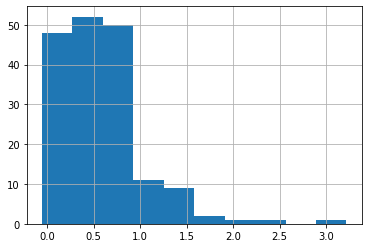

In [726]:
price_comp_df.perc_increase.hist()

- on average prices of properties sold more than one rise by around 57%
- condition or grade changes and a possible renovation did not occur

possible reasons:
- strong price fluctuations
- people sell their properties way underprice sometimes
- selling to realtor who knows "real" price of property

In [727]:
df['year'] = df.date.apply(lambda x: pd.to_datetime(x).year)
df['month'] = df.date.apply(lambda x: pd.to_datetime(x).month)
df['YYMM'] = list(zip(df.year.tolist(), df.month.tolist()))

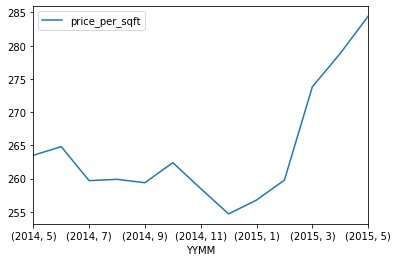

In [728]:
df.groupby('YYMM').mean()[['price_per_sqft']].plot()

# Prediction

In [729]:
df = df.drop(['month', 'day', 'above_avg', 'below_avg', 'YYMM'], axis=1)

In [730]:
X = df.drop(['price', 'date', 'id'], axis=1)
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [731]:
zipprice_df = X_train.groupby('zipcode').mean()[['price_per_sqft']].astype(int)
zipprice_df.rename(columns={"price_per_sqft": "price_in_zip"}, inplace=True)
X_train = X_train.merge(zipprice_df, on='zipcode')
X_test = X_test.merge(zipprice_df, on='zipcode')

In [737]:
df = df.merge(zipprice_df, on='zipcode')

In [732]:
X = df.drop(['price_per_sqft', 'zipcode'], axis=1)

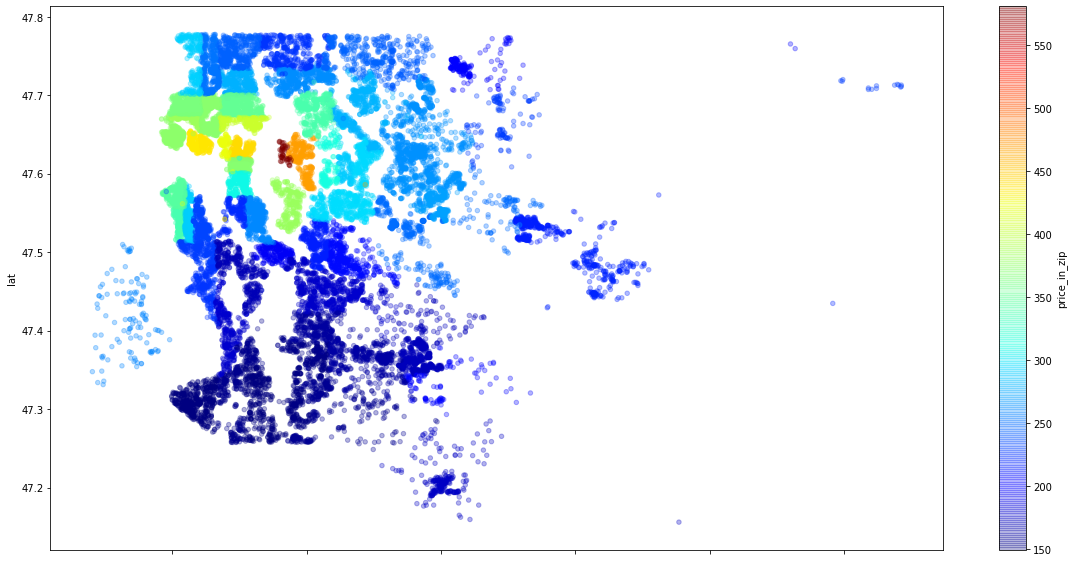

In [739]:
df.plot(kind='scatter', x='long', y='lat', alpha=0.3,
        figsize=(20,10),
        c='price_in_zip', cmap=plt.get_cmap('jet'), 
        colorbar=True,
)

In [ ]:
df.head()